# Testing the MLE Inference Outcome from Havercroft's and Didelez's Model

In [1]:
import math

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO, autoguide, Predictive
from numpyro.infer import init_to_feasible
import pandas as pd
import tqdm

from frugalCopyla import copula_lpdfs
from frugalCopyla.model	import CopulaModel

import utils_inference as utils_inf

numpyro.enable_x64() 

/Users/danielmanela/.virtualenvs/frugalCopyla/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We define two models for both the randomised and observational Havercroft and Didelez example. The difference between the two here is that generative Bernouilli for $B$ in the randomised setup is constant.

In [2]:
rho_ly = 0.7
obs_mod = utils_inf.create_didelez_model(rho_ly, is_rct=False)
rct_mod = utils_inf.create_didelez_model(rho_ly, is_rct=True)

N_RUNS = 100
N_SAMPLES = 50_000 # Sampled from 4 separate chains, so len(data) is equal to 200_000

Storing the true parameters used to generate the model for comparison later on:

In [3]:
true_params = {
    'a_const_sigmoid': 0.0,
    'alpha_0': 0.3,
    'alpha_a': 0.2,
    'gamma_0': -0.3,
    'gamma_a': 0.4,
    'gamma_l': 0.3,
    'gamma_al': 0.,
    'beta_0': -0.5,
    'beta_a': 0.2,
    'beta_b': 0.3,
    'beta_ab': 0.,
    'rho_ly': round(rho_ly, 2)
}

In [4]:
mod = utils_inf.create_didelez_model(rho_ly, is_rct=False)
sim_output = mod.simulate_data(1000, 1000, joint_status='mixed', seed=1)
data_R = pd.DataFrame(sim_output['data'])[['A', 'B', 'L', 'Y']].rename(
    columns={'A': 'A0', 'B': 'A1'}
)
data_R.iloc[1:50000].to_csv('didelez_samples.csv', index=False)
data = data_R.rename(
    columns={'A0': 'a_obs', 'A1': 'b_obs', 'L': 'l_obs', 'Y': 'y_obs'}
).to_dict('list')
for k in data.keys():
    data[k] = jnp.array(data[k])

In [5]:
## To run prior predictive checks 
# for k in data.keys():
#     data[k] = jnp.array([])

We can do Bayesian sampling of the likelihood:

In [6]:
kernel = numpyro.infer.NUTS(utils_inf.obs_didelez_model_inference)#, init_strategy=init_to_feasible)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=250, num_samples=500, num_chains=1, progress_bar=True)
mcmc.run(jax.random.PRNGKey(0), 
         data=data)
mcmc.print_summary()

sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:17<00:00, 42.34it/s, 15 steps of size 2.32e-01. acc. prob=0.90]



                       mean       std    median      5.0%     95.0%     n_eff     r_hat
  a_const_sigmoid      0.01      0.03      0.01     -0.04      0.06    649.34      1.00
          alpha_0      0.30      0.02      0.30      0.27      0.34    339.71      1.01
          alpha_a      0.20      0.03      0.20      0.15      0.24    364.39      1.00
           beta_0     -0.51      0.03     -0.51     -0.56     -0.48    195.02      1.00
           beta_a      0.22      0.04      0.22      0.15      0.27    237.89      1.00
          beta_ab      0.00      0.04     -0.00     -0.08      0.07    225.68      1.00
           beta_b      0.30      0.03      0.30      0.25      0.35    194.61      1.00
          gamma_0     -0.17      0.06     -0.17     -0.27     -0.08    280.57      1.00
          gamma_a      0.23      0.09      0.22      0.05      0.35    214.51      1.00
         gamma_al      0.11      0.05      0.11      0.04      0.20    289.07      1.00
          gamma_l      0.21    

Or just run a MLE estimate instead (quicker)

In [7]:
run = utils_inf.mle_inference(data, utils_inf.obs_didelez_model_inference, 0.05, 3000, 1, True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:28<00:00, 103.85it/s, init loss: 82714.7553, avg. loss [2851-3000]: 56728.8184]


In [8]:
run.params

{'a_const_sigmoid_auto_loc': Array(0.00800004, dtype=float64),
 'alpha_0_auto_loc': Array(0.28269291, dtype=float64),
 'alpha_a_auto_loc': Array(0.20076044, dtype=float64),
 'beta_0_auto_loc': Array(-0.50599477, dtype=float64),
 'beta_a_auto_loc': Array(0.1957287, dtype=float64),
 'beta_ab_auto_loc': Array(0.0248027, dtype=float64),
 'beta_b_auto_loc': Array(0.28857754, dtype=float64),
 'gamma_0_auto_loc': Array(-0.22141189, dtype=float64),
 'gamma_a_auto_loc': Array(0.29788168, dtype=float64),
 'gamma_al_auto_loc': Array(0.04659635, dtype=float64),
 'gamma_l_auto_loc': Array(0.25886453, dtype=float64),
 'rho_ly_auto_loc': Array(0.6956315, dtype=float64)}

In the following sections, we generate `N_RUNS` different batches of data drawn from the Observational and Randomised model, and calculate an MLE estimate. We bootstrap the parameter estimates for each of the runs and compare the distribution to the true parameter values stated above.

## Check runtimes of llhoods

In [8]:
def temp_bivariate_gaussian_copula_lpdf(u, v, rho) -> float:
    u_2 = jnp.square(u)
    v_2 = jnp.square(v)
    rho_2 = jnp.square(rho)
    llhood = (
        -0.5 * jnp.log(1 - rho_2) - (
            rho_2 * (u_2 + v_2) - 2 * rho * u * v
        ) / (2 * (1 - rho_2))
    )
    return llhood

def temp_corr_multivar_gaussian_copula_lpdf(u, v, rho) -> float:
    corr = jnp.array([[1., rho], [rho, 1.]])
    rvs = jnp.array([u, v])
    llhood = (
        dist.MultivariateNormal(
           covariance_matrix=corr
        ).log_prob(rvs)
        + 0.5 * len(rvs) * jnp.log(2 * jnp.pi)
        + 0.5 * jnp.sum((rvs ** 2))
    )
    return llhood

In [18]:
import time

N_iter = 100_000
u = 0.2; v = -0.4

st = time.process_time()
for _ in range(N_iter):
    biv_llhood = temp_bivariate_gaussian_copula_lpdf(u, v, rho_ly)
biv_runtime = time.process_time() - st
print(f'Biv runtime: {biv_runtime}')

st = time.process_time()
for _ in range(N_iter):
    mat_llhood = temp_corr_multivar_gaussian_copula_lpdf(u, v, rho_ly)
mv_runtime = time.process_time() - st
print(f'MV runtime: {mv_runtime}')

print(f'MV Copula takse {round(mv_runtime/biv_runtime, 2)} times longer than the Biv case')

Biv runtime: 3.016776
MV runtime: 25.966769999999997
MV Copula takse 8.61 times longer than the Biv case


Doesn't look like much difference in drawing an individual sample

### Observational Model

Let's generate runs from the observational model.

In [9]:
%%time
numpyro.set_host_device_count(4)
obs_results = utils_inf.sim_run(
    obs_mod, 
    utils_inf.obs_didelez_model_inference,
    num_samples=N_SAMPLES,
    svi_iter=1500,
    lr=0.005,
    runs=N_RUNS,
    progress_bar=False
)

Run: 1 / 100. Loss Pct diff: -0.0002442776355138502 %.
Run: 2 / 100. Loss Pct diff: -0.0001406873234281036 %.
Run: 3 / 100. Loss Pct diff: -0.0003618795325331946 %.
Run: 4 / 100. Loss Pct diff: -0.0015739728816168512 %.
Run: 5 / 100. Loss Pct diff: -0.004263075882368865 %.
Run: 6 / 100. Loss Pct diff: -1.0793411888478987e-06 %.
Run: 7 / 100. Loss Pct diff: -0.001609777593132088 %.
Run: 8 / 100. Loss Pct diff: -2.1126030437609693e-06 %.
Run: 9 / 100. Loss Pct diff: -5.0540993871561114e-05 %.
Run: 10 / 100. Loss Pct diff: -0.00017008769522687856 %.
Run: 11 / 100. Loss Pct diff: -0.0012177804169706044 %.
Run: 12 / 100. Loss Pct diff: -3.565480762074132e-05 %.
Run: 13 / 100. Loss Pct diff: -6.703490022789379e-05 %.
Run: 14 / 100. Loss Pct diff: -9.400621088493144e-06 %.
Run: 15 / 100. Loss Pct diff: -5.381024734327762e-05 %.
Run: 16 / 100. Loss Pct diff: -1.1434229171601293e-07 %.
Run: 17 / 100. Loss Pct diff: -0.002243141072099173 %.
Run: 18 / 100. Loss Pct diff: -0.00025684401077517334 %

#### Losses for all 100 runs appear to all converge by 1000 steps

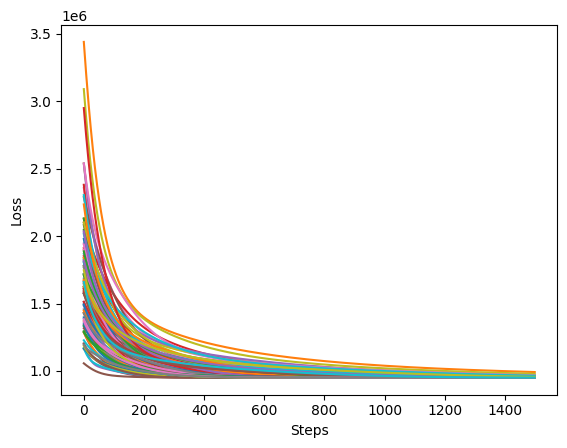

In [10]:
plt.plot(obs_results['losses'].T);
plt.xlabel("Steps");
plt.ylabel("Loss");

In [11]:
obs_params = dict()
for k, v in obs_results['params'].items():
    obs_params[k[:-9]] = obs_results['params'][k]

#### Comparison of parameter estimates to true values

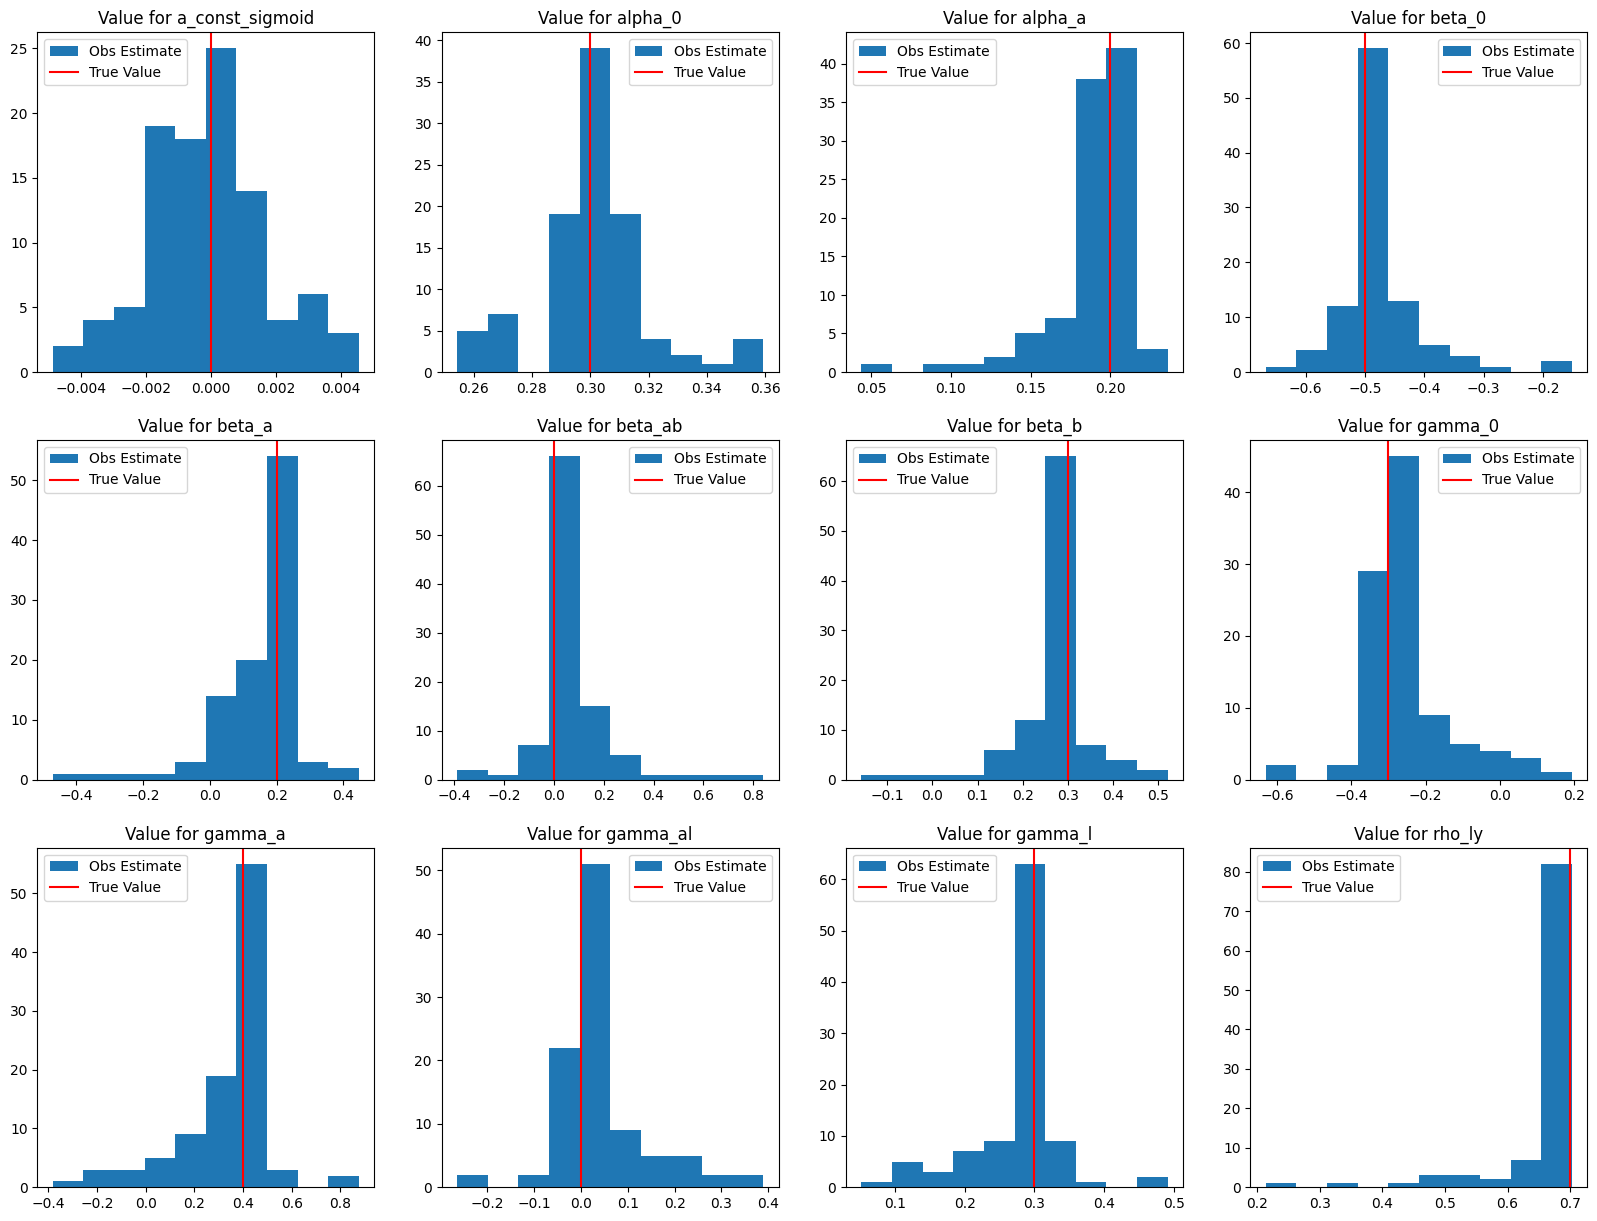

In [13]:
f, axs = plt.subplots(3, 4, figsize=(20, 15))

param_names = list(obs_params.keys())
for i, ax in enumerate(f.axes):
    ax.hist(np.array(obs_params[param_names[i]]), label='Obs Estimate')
    ax.axvline(true_params[param_names[i]], color='r', label='True Value')
    # li.set_label('True Value')
    ax.title.set_text(f'Value for {param_names[i]}')
    ax.legend()

The estimates appear reasonable (albeit some a bit skewed) except for the estimate for `rho_ly` which has a substantial bias.

## Randomised Model

In [21]:
%%time
rct_results = utils_inf.sim_run(
    rct_mod, 
    utils_inf.rct_didelez_model_inference,
    num_samples=N_SAMPLES,
    svi_iter=1000,
    lr=0.005,
    runs=N_RUNS,
    progress_bar=False
)

Run: 1 / 100. Loss Pct diff: -0.010854188862807094 %.
Run: 2 / 100. Loss Pct diff: -0.010732358964005213 %.
Run: 3 / 100. Loss Pct diff: -0.013619567361734648 %.
Run: 4 / 100. Loss Pct diff: -5.277133925426234e-05 %.
Run: 5 / 100. Loss Pct diff: -2.5080699300085624e-06 %.
Run: 6 / 100. Loss Pct diff: -6.356775958896823e-06 %.
Run: 7 / 100. Loss Pct diff: -0.010312642585464436 %.
Run: 8 / 100. Loss Pct diff: -0.0051893439090934385 %.
Run: 9 / 100. Loss Pct diff: -0.001056703066962849 %.
Run: 10 / 100. Loss Pct diff: -5.575063667013122e-05 %.
Run: 11 / 100. Loss Pct diff: -4.974200998302548e-05 %.
Run: 12 / 100. Loss Pct diff: -0.011378304545835067 %.
Run: 13 / 100. Loss Pct diff: -4.171048833326534e-05 %.
Run: 14 / 100. Loss Pct diff: -0.00900543028258458 %.
Run: 15 / 100. Loss Pct diff: -0.0016747675944604526 %.
Run: 16 / 100. Loss Pct diff: -1.1262795816815738e-05 %.
Run: 17 / 100. Loss Pct diff: -0.007095016821581004 %.
Run: 18 / 100. Loss Pct diff: -0.0032021936372852214 %.
Run: 19 

#### Again, the losses appear to converge nicely for all `N_RUNS` runs

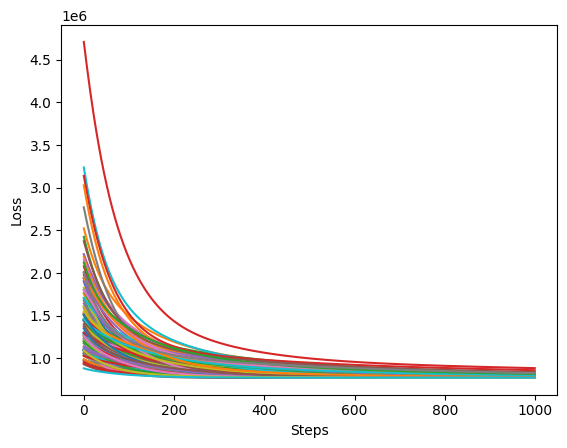

In [22]:
plt.plot(rct_results['losses'].T);
plt.xlabel("Steps");
plt.ylabel("Loss");

#### The Parameter estimates all appear sensible here too **except** for the correlation term `rho_LY`.

In [23]:
rct_params = dict()
for k, v in rct_results['params'].items():
    rct_params[k[:-9]] = rct_results['params'][k]

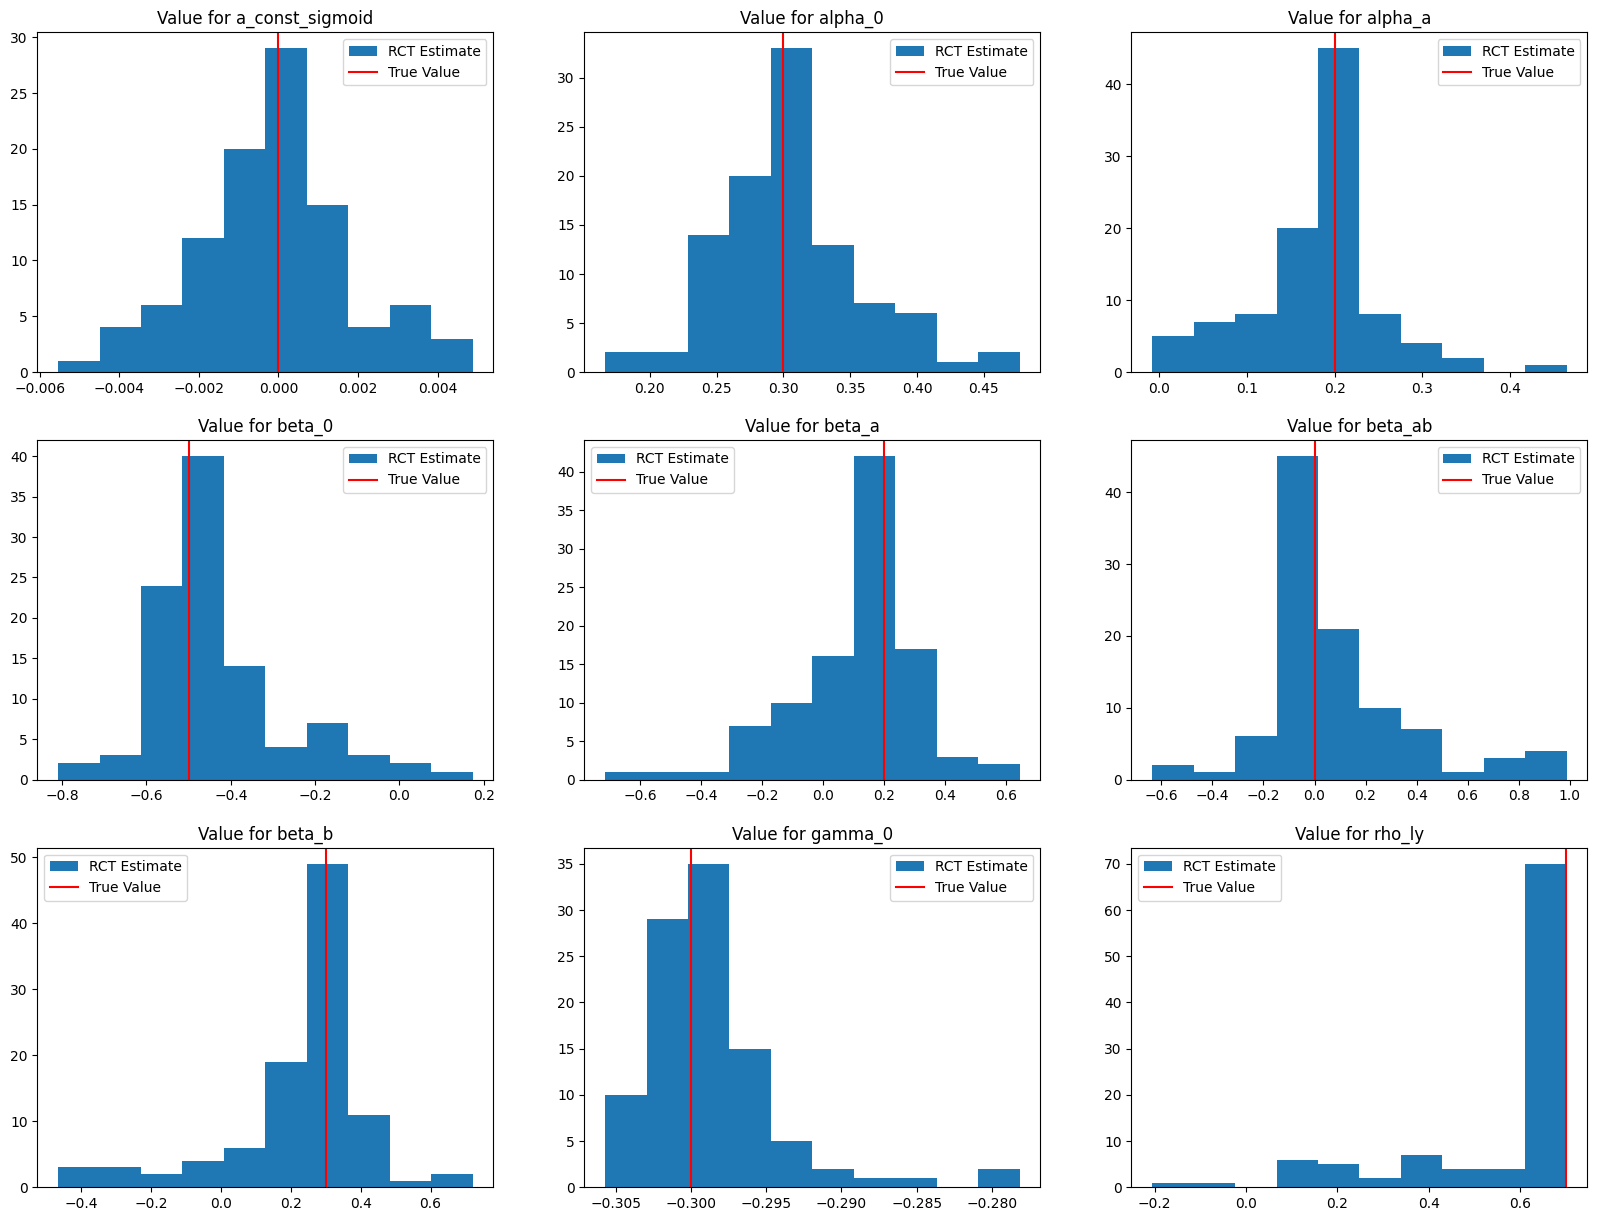

In [24]:
f, axs = plt.subplots(3, 3, figsize=(20, 15))

param_names = list(rct_params.keys())
for i, ax in enumerate(f.axes):
    ax.hist(np.array(rct_params[param_names[i]]), label='RCT Estimate')
    ax.axvline(true_params[param_names[i]], color='r', label='True Value')
    # li.set_label('True Value')
    ax.title.set_text(f'Value for {param_names[i]}')
    ax.legend()

## Check bias of `rho_ly` inference as a function of `rho_ly`

In [ ]:
rho_ly_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
results_dict = {}
for rho_ly in rho_ly_list:
    obs_mod = utils_inf.create_didelez_model(rho_ly, is_rct=False)
    numpyro.set_host_device_count(4)
    obs_results = utils_inf.sim_run(
        obs_mod, 
        utils_inf.obs_didelez_model_inference,
        num_samples=N_SAMPLES,
        svi_iter=1500,
        lr=0.005,
        runs=N_RUNS,
        progress_bar=False
    )
    results_dict[rho_ly] = obs_results['params']['rho_ly_auto_loc']

In [ ]:
f, axs = plt.subplots(len(results_dict), 1, figsize=(10, 35))

for i, ax in enumerate(f.axes):
    ax.hist(np.array(results_dict[rho_ly_list[i]]), label='Obs Estimate')
    ax.axvline(rho_ly_list[i], color='r', label='True Value')
    # li.set_label('True Value')
    ax.title.set_text(f'Value for {rho_ly_list[i]}')
    ax.legend()    